In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

In [2]:
pricing_df = pd.read_csv('/Users/slaw/osobiste/gielda/CCC_pricing.csv')

In [3]:
pricing_df.head(5)

,date,open,high,low,close,volume
0,2004-12-02,10.10,10.25,9.85,9.95,252192
1,2004-12-03,9.95,9.95,9.45,9.80,47657
2,2004-12-06,9.75,9.75,9.50,9.60,24404
3,2004-12-07,9.50,9.50,9.15,9.40,22520
4,2004-12-08,9.40,9.40,9.10,9.35,11571


In [39]:
def find_trend(df, t, label='close', show_graph=False, classification=False):
    """
    Finds trend in pricing data (df) over last t days. Returns slope of the fitted straight line.
    """
    y = df.tail(t)[label].to_numpy()
    x = np.array(range(1,len(y)+1))
    A = np.vstack([x, np.ones(len(x))]).T
    # fits: y = ax + b
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    if show_graph:
        plt.plot(x, y, '-', label='Original data', markersize=10)
        plt.plot(x, a*x + b, 'r', label='Fitted line')
        plt.legend()
        plt.show()
    # arbitrary classification. no science here.
    if classification:
        if a >= -.25 and a <= .25:
            return 'horizontal'
        elif a > .25:
            return 'uptrend'
        elif a < -.25:
            return 'downward'
    if a >= .25:
        return 1
    elif a < -.25:
        return -1
    return 0

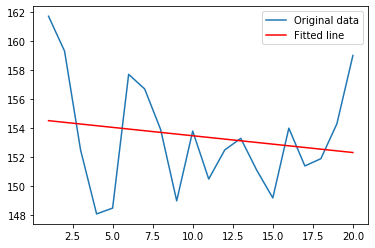

'horizontal'

In [5]:
find_trend(pricing_df, 20, show_graph=True, classification=True)

#### Support and Resistance rules:
====================

A simple trading rule based on the notion of support and resistance (S&R) is to buy when the closing price exceeds the maximum price over the previous n days,
and sell when the closing price is less than the minimum price over the previous n days.

Rather than base the rules on the maximum/minimum over a prespecified range of days, the S&R trading rules can also be based on an alternate definition of local extrema.
That is, define a minimum/maximum to be the most recent closing price that is less/greater than the e previous closing prices.

As with the MA rules, a fixed percentage band filter, b, and a time delay filter, d, can be included. Also, positions can be held for a prespecified number of days, c.

Parameters:
n - 5 number of days for the channel
- 5, 10, 15, 20, 25, 50, 100, 150, 200, 250 (10 vals)

e - used for an alternative definition of extrema
- 2, 3, 4, 5, 10, 20, 25, 50, 100, 200 (10 vals)

b - 0.001, 0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05 (8 vals)
d - 2, 3, 4, 5 (4 vals)
c - 5, 10, 25, 50 (4 vals)

Number of rules:
((1+c) (n+e)) + ((1+c) (b(n+e))) + (dc*(n+e)) = 1220

In [36]:
def find_support_resistance(df, t, label='close', show_graph=False, e=False, b=False):
    """
    df - dataframe with pricing data
    t - look-back period
    e - Should be int. Used for alternative supprot/resistance definition. That is, most recent closing price has 
        to be less/greater than the e previous prices.
    b - The fixed percentage band filter requires the buy or sell signal to exceed the support/resistance by 
        a fixed multiplicative amount, b.
        
    If lookback period is 5, then last price is current. So it actually takes price from -1d and look 4d back
    """
    y = df.tail(t)[label].to_numpy()
    price = y[-1] # last day is treated as current
    y = y[:-1] # look t-1 days back
    # "global" definition of supp/res 
    if not e or e>t:
        support = min(y)
        resistance = max(y)
    # "local" definition
    elif e:
        # support
        past_times_smaller_than_itself = list(
            map(lambda x: np.where(y[:x[0]]<x[1])[0].size, list(enumerate(y)))
        )
        smaller_than_e_xtimes_idxs = np.where(np.array(past_times_smaller_than_itself) < e)[0]
        support_idx = max(smaller_than_e_xtimes_idxs)
        support = y[support_idx]
        # resistance
        past_times_bigger_than_itself = list(
            map(lambda x: np.where(y[:x[0]]>x[1])[0].size, list(enumerate(y)))
        )
        bigger_than_e_xtimes_idxs = np.where(np.array(past_times_smaller_than_itself) > e)[0]
        resistance_idx = max(bigger_than_e_xtimes_idxs)
        resistance = y[resistance_idx]
    if show_graph:
        x = np.array(range(1,len(y)+1))
        plt.plot(x, y, '-', label='Original data', markersize=10)
        plt.plot(x, [support for _ in x], 'green', label='Supprot')
        plt.plot(x, [resistance for _ in x], 'red', label='Resistance')
        plt.legend()
        plt.show()
        
    if not b:
        if price > resistance:
            return 1
        elif price < support:
            return -1
        return 0
    if price > resistance+(resistance*b):
        return 1
    elif price < support-(support*b):
        return -1
    return 0

[150.5 152.5 153.3 151.1 149.2 154.  151.4 151.9 154.3]
159.0


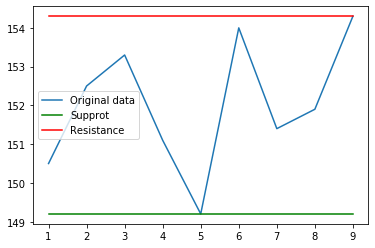

1


In [38]:
signal = find_support_resistance(pricing_df, 10, show_graph=True, e=50, b=.01)
print(signal)

In [9]:
"""
???

- set of inputs and rules definition
{
    'formation': {key: x, params_x},
    'contexts': [
        {'key': 'y1', params_y1},
        {'key': 'y2', params_y2},
    ],
    'constraints':[
        {'key': 'z_1', params_z1},
        {'key': 'z_2', params_z1},
    ]
}

option 1:
- apply/iterate function for:
    - formation and all contexts
- go over 2nd time to apply contraints

option 2:
- go over dasets just once
    + formations, contexts etc. as you go
    + contstraints (band filter, deley filter, holding filter) as you go
- looks like better option to be honest...



moj bactester uzywa normalnej petli (i dict a nie pd i iterrows). pytanie czy zawsze mi sie oplaca implemenotwac 
formations uzywajac jednej biblioteki... czy olac to... i uzywac roznych w zaleznosci od rule.
(to drugie wydaje sie sensowniejsze)
""";

In [10]:
test_config = {
    'rules': [
        {
            'id': 'trend',
            'type': 'simple',
            'params': {'t': 20}
        }
        {
            'id': 'support/resistance',
            'type': 'simple'
            'params':{'t': 6, 'e': None, b=.01}
        },
        {
            'id': 'support/resistance with trend',
            'type': 'convoluted',
            'params': '',
            'simple_rules': ['trend', 'support/resistance']
        }
    ]
    'strategy': {
        'type': 'fixed'
        'rules': ['support/resistance with trend', 'trend']
    }
}